# Job Change of Data Scientists | Data Science Project | Data Preprocessing

> Data from [Kaggle](https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists) with modification in problem context.

*This project was completed as a part of Rakamin Academy Data Science Bootcamp.*

Ascencio, a leading Data Science agency, offers training courses to companies to enhance their employees' skills. Companies want to predict which employees are **unlikely to seek a job change** after completing the course, as well as identify those who are **likely to finish it quickly**. By focusing on employees who are committed to staying and can contribute sooner, Ascencio helps companies optimize their training investments.

To achieve this, Ascencio will build two machine learning models: one to predict the training hours needed for an employee to complete the course, and another to predict whether an employee will seek a job change or not.

# Prepare Everything!

In [102]:
# import library
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
%matplotlib inline
from lightgbm import LGBMClassifier, LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('matplotlib version : ',mpl.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  2.2.1
pandas version :  2.2.3
matplotlib version :  3.10.0
seaborn version :  0.13.2


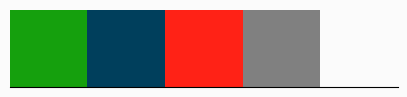

In [103]:
# color palette
green = '#15a00d'
blue = '#003f5c'
red = '#ff2216'
gray = 'gray'
bg_color = '#fbfbfb'
sns.palplot([green,blue,red,gray,bg_color])

In [104]:
# default setting
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.facecolor"] = bg_color
plt.rcParams["axes.facecolor"] = bg_color
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams['ytick.major.size'] = 0
plt.rcParams['ytick.minor.size'] = 0
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['axes.axisbelow'] = True

In [105]:
# read the data
df_train = pd.read_csv(r'Data/aug_train.csv')
df_test = pd.read_csv(r'Data/aug_test.csv')

# Data Preprocessing

## A. Feature Transformation

We only need to feature transformation column training_hours using log-transformation

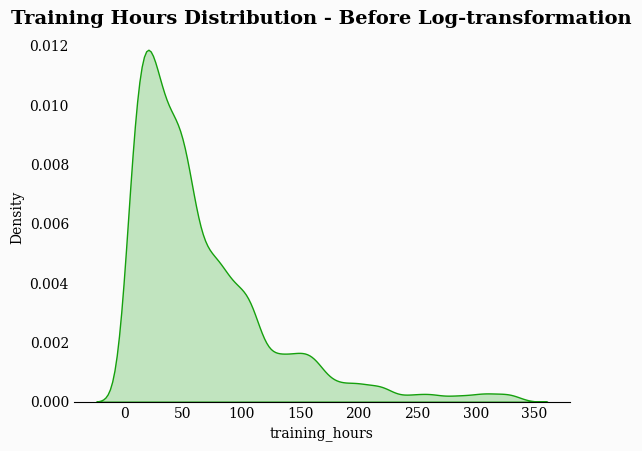

In [106]:
sns.kdeplot(df_train['training_hours'], color=green, shade=True)
plt.title('Training Hours Distribution - Before Log-transformation', fontsize=14, fontweight='bold')
plt.show()

In [107]:
# log transformation
df_train['training_hours'] = np.log1p(df_train['training_hours']) # using log1p to avoid log(0)

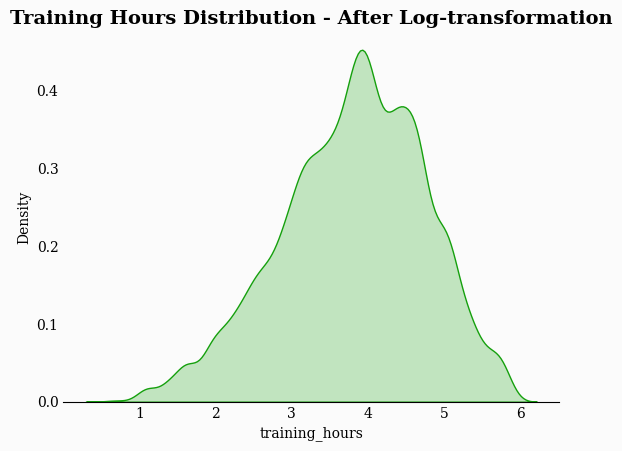

In [108]:
sns.kdeplot(df_train['training_hours'], color=green, shade=True)
plt.title('Training Hours Distribution - After Log-transformation', fontsize=14, fontweight='bold')
plt.show()

## B. Handle Outlier

In [109]:
# function to handle outlier with IQR
def remove_outlier(df, col):
    # q1 and q3
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1 # interquartile range

    treshold_low  = q1-1.5*iqr
    treshold_high = q3+1.5*iqr

    df_out = df.loc[(df[col] > treshold_low) & (df[col] < treshold_high)]
    return df_out

We just need to handle outlier in column training_hours

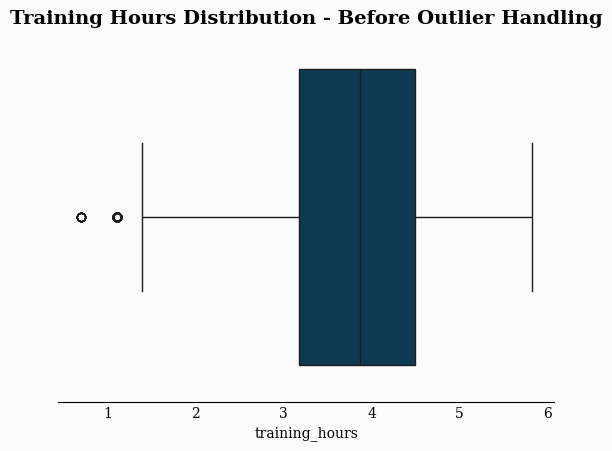

In [110]:
sns.boxplot(x='training_hours', data=df_train, color=blue)
plt.title('Training Hours Distribution - Before Outlier Handling', fontsize=14, fontweight='bold')
plt.show()

In [111]:
# remove outlier
initial = df_train.shape[0] # it wil be using as a constant
before = df_train.shape[0]
df_train = remove_outlier(df_train, 'training_hours')
after = df_train.shape[0]
print(f'Number of outlier removed : {before-after} or {((before-after)/initial)*100:.2f}% total train data')

Number of outlier removed : 105 or 0.55% total train data


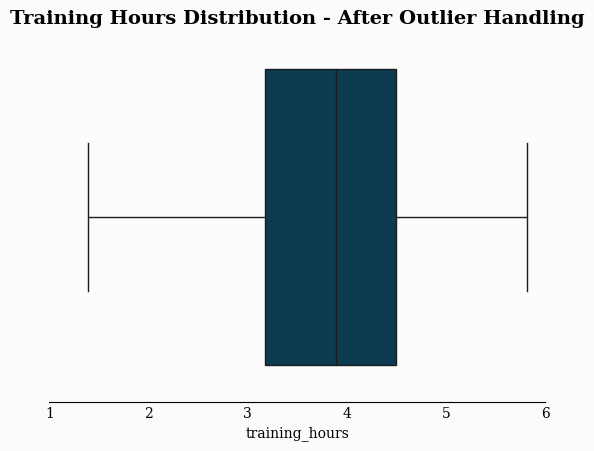

In [112]:
sns.boxplot(x='training_hours', data=df_train, color=blue)
plt.title('Training Hours Distribution - After Outlier Handling', fontsize=14, fontweight='bold')
plt.xlim(1,6)
plt.show()

## D. Feature Selection

We will drop column enrollee_id and city

In [113]:
# drop column enrollee_id and city
df_train.drop(['enrollee_id','city'], axis=1, inplace=True)
df_train.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,3.610918,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,3.871201,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,4.430817,0.0
3,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,3.970292,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,2.197225,0.0


## E. Feature Revision

We will rename, grouping, and imputation data based on 1_EDA.ipynb analysis

In [115]:
# rename relevent_experience to relevant_experience
df_train.rename(columns={'relevent_experience':'relevant_experience'}, inplace=True)

# grouping city_development_index
df_train['city_development_index'] = df_train['city_development_index'].apply(lambda x: '<=0.6' if x <= 0.6
                                                                                else '0.6-0.7' if x <= 0.7
                                                                                else '0.7-0.8' if x <= 0.8
                                                                                else '0.8-0.9' if x <= 0.9
                                                                                else np.nan if pd.isna(x)
                                                                                else '0.9-1.0')

# grouping relevant_experience
df_train['relevant_experience'] = df_train['relevant_experience'].apply(lambda x: True if x == "Has relevent experience" 
                                                 else np.nan if pd.isna(x) else False)

# grouping enrolled_university
df_train['enrolled_university'] = df_train['enrolled_university'].apply(lambda x: "No Enroll" if x == "no_enrollment"
                                                                        else "Full Time" if x == "Full time course" 
                                                                        else np.nan if pd.isna(x) else "Part Time")

# grouping and imputation major_discipline
df_train['major_discipline'] = df_train['major_discipline'].apply(lambda x: "STEM" if x == "STEM"
                              else "No Major" if x == "No Major" 
                              else np.nan if pd.isna(x) else "Non-STEM")
df_train['major_discipline'] = np.where((df_train['education_level'].isin(['Graduate', 'Masters'])) & (df_train['major_discipline'] == 'No Major'), np.nan, 
                        np.where((df_train['education_level'].isin(['Primary School', 'High School'])) & (df_train['major_discipline'].isnull()),'No Major',df_train['major_discipline']))

# grouping experience
df_train['experience'] = df_train['experience'].apply(lambda x: "Early Career" if x in ['<1','1','2','3','4']
                                                        else "Mid Career" if x in ['5','6','7','8','9','10']
                                                        else "Senior Career" if x in ['11','12','13','14','15']
                                                        else np.nan if pd.isna(x) else "High Experience")

# grouping company_size
df_train['company_size'] = df_train['company_size'].apply(lambda x: "Medium" if x in ['100-500', '500-999']
                                                            else "Large" if x in ['1000-4999', '5000-9999']
                                                            else "Very Large" if x in ['10000+'] 
                                                            else np.nan if pd.isna(x) else "Small")

# rename company_type
df_train['company_type'] = df_train['company_type'].apply(lambda x: "Early Startup" if x == "Early Stage Startup" else x)

# check data
df_train.sample(10)

,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
8991,0.6-0.7,NaN,True,No Enroll,Graduate,STEM,Senior Career,Small,Pvt Ltd,>4,2.890372,0.0
3289,0.9-1.0,NaN,True,NaN,Graduate,STEM,Early Career,Small,Funded Startup,1,3.970292,0.0
2434,0.9-1.0,NaN,True,No Enroll,Masters,STEM,Senior Career,Very Large,Pvt Ltd,never,4.700480,0.0
13548,0.6-0.7,Male,False,Full Time,Graduate,STEM,Early Career,Medium,Pvt Ltd,1,3.555348,1.0
18397,0.9-1.0,Male,True,No Enroll,Masters,STEM,High Experience,Large,Pvt Ltd,>4,4.465908,0.0
12060,0.8-0.9,NaN,True,No Enroll,Graduate,STEM,High Experience,NaN,NaN,>4,3.988984,0.0
14995,0.9-1.0,Male,True,No Enroll,Graduate,Non-STEM,Mid Career,Small,NGO,1,3.637586,0.0
17738,0.9-1.0,Male,True,No Enroll,Graduate,STEM,High Experience,Small,Pvt Ltd,1,3.401197,0.0
16588,0.9-1.0,NaN,True,No Enroll,Graduate,STEM,High Experience,NaN,NaN,1,2.772589,0.0
14060,0.7-0.8,Male,True,No Enroll,Graduate,STEM,Mid Career,Medium,Pvt Ltd,2,4.634729,0.0


## F. Type Data

In [121]:
# check type data
print(df_train.info())
# relevant_experience have bool type since it only yes or no value

<class 'pandas.core.frame.DataFrame'>
Index: 19053 entries, 0 to 19157
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  19053 non-null  object 
 1   gender                  14577 non-null  object 
 2   relevant_experience     19053 non-null  bool   
 3   enrolled_university     18671 non-null  object 
 4   education_level         18595 non-null  object 
 5   major_discipline        18345 non-null  object 
 6   experience              18988 non-null  object 
 7   company_size            13153 non-null  object 
 8   company_type            12953 non-null  object 
 9   last_new_job            18636 non-null  object 
 10  training_hours          19053 non-null  float64
 11  target                  19053 non-null  bool   
dtypes: bool(2), float64(1), object(9)
memory usage: 1.6+ MB
None


In [130]:
# change type 'target' to boolean
df_train['target'] = df_train['target'].astype(bool)
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 19053 entries, 0 to 19157
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  19053 non-null  object 
 1   gender                  14577 non-null  object 
 2   relevant_experience     19053 non-null  bool   
 3   enrolled_university     18671 non-null  object 
 4   education_level         18595 non-null  object 
 5   major_discipline        18345 non-null  object 
 6   experience              18988 non-null  object 
 7   company_size            13153 non-null  object 
 8   company_type            12953 non-null  object 
 9   last_new_job            18636 non-null  object 
 10  training_hours          19053 non-null  float64
 11  target                  19053 non-null  bool   
dtypes: bool(2), float64(1), object(9)
memory usage: 1.6+ MB
None


## G. Handle Missing Value

We will using LGBMClasifier (ML model) to imputate missing data since missing value is only on categorical feature

In [118]:
# check missing value
print("Missing value before imputation")
miss_perc = df_train.isna().sum()/df_train.shape[0]*100
miss = pd.DataFrame({'Missing Count': df_train.isna().sum(),
                     'Missing %': np.round(miss_perc,2)}).sort_values('Missing %', ascending=False)
display(miss)

Missing value before imputation


,Missing Count,Missing %
company_type,6100,32.02
company_size,5900,30.97
gender,4476,23.49
major_discipline,708,3.72
education_level,458,2.40
last_new_job,417,2.19
enrolled_university,382,2.00
experience,65,0.34
relevant_experience,0,0.00
city_development_index,0,0.00
